<a href="https://colab.research.google.com/github/vladislavdarii/Ship-classification-using-Machine-Learning-techniques/blob/main/07_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title 1.0 Imports for Model Training
#Train and test data variables have been saved executing 0.5 to 3.2

import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal

#Machine learning
from keras import models
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU
from keras.layers import Dropout
import matplotlib.pyplot as plt
import librosa
#Writing and loading variables
import pickle
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd

#Model visualization
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization
from keras.callbacks import ReduceLROnPlateau

#Mount drive
from google.colab import drive
drive.mount('/content/drive')

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

Mounted at /content/drive


In [ ]:
#@title 1.1 Function: Class Accuracy Plot and Metrics

def plot_class_acc(y_val, y_pred, strr):

  # Initialize the lists for correctly and incorrectly predicted values
  correct_preds = [0, 0, 0, 0]
  incorrect_preds = [0, 0, 0, 0]

  # Loop over the samples in y_test and y_pred
  for i in range(len(y_val)):
      if y_val[i] == y_pred[i]:
          correct_preds[y_val[i]] += 1
      else:
          incorrect_preds[y_val[i]] += 1

  # Set the colors for the bars
  bar_colors = ['#009965', '#a52a2b']

  # Create the bar chart with two parts for each bar
  fig, ax = plt.subplots(figsize=(8, 5))
  ax.bar(range(len(correct_preds)), correct_preds, color=bar_colors[0], label='Correct Predictions')
  ax.bar(range(len(incorrect_preds)), incorrect_preds, bottom=correct_preds, color=bar_colors[1], label='Incorrect Predictions')

  for i, (corr, incorr) in enumerate(zip(correct_preds, incorrect_preds)):
      ax.text(i, corr/2, str(corr), ha='center', va='center', color='white', fontsize=10, fontweight='bold')
      ax.text(i, corr + incorr/2, str(incorr), ha='center', va='center', color='white', fontsize=10, fontweight='bold')

  # Set the x-ticks and labels
  ax.set_xticks(range(len(correct_preds)))
  ax.set_xticklabels(['Class A', 'Class B', 'Class C', 'Class D'])

  # Set the labels and title
  ax.set_xlabel('Boat Type')
  ax.set_ylabel('Count')
  ax.set_title(strr)

  # Add the legend
  ax.legend()

  # Show the plot
  plt.show()

  # #Metric calculation
  # Create confusion matrix
  cm = confusion_matrix(y_val, y_pred)

  # Convert the confusion matrix to a pandas DataFrame
  confusion_matrix_df = pd.DataFrame(cm, columns=['Class A', 'Class B', 'Class C', 'Class D'])

  # Calculate metrics
  metrics_df = calculate_metrics(confusion_matrix_df.values)

  # Print the results
  print("Confusion Matrix:")
  print(confusion_matrix_df)
  print("\nMetrics:")
  print(metrics_df)

  return metrics_df, confusion_matrix_df

def calculate_metrics(confusion_matrix):
    tp = np.diagonal(confusion_matrix)
    fp = confusion_matrix.sum(axis=0) - tp
    fn = confusion_matrix.sum(axis=1) - tp
    tn = confusion_matrix.sum() - (tp + fp + fn)

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * (precision * recall) / (precision + recall)
    accuracy = np.trace(confusion_matrix) / confusion_matrix.sum()

    metrics_dict = {
        'Class': ['Class 0', 'Class 1', 'Class 2', 'Class 3'],
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1_score,
        'Accuracy': accuracy
    }
    #Get rid of NaN values
    metrics_dict = pd.DataFrame(metrics_dict)
    metrics_dict.fillna(0, inplace=True)
    return metrics_dict

#@title 5.1 Get final metrics

def metrics_avg_var(metrics):
 row = [0,1,2,3]
 Precision = []
 Recall = []
 F1_Score = []
 Accuracy = []
 Precision_var = []
 Recall_var = []
 F1_Score_var = []
 Accuracy_var = []

 for a in row:
  Precision.append(np.average([df.loc[a, 'Precision'] for df in metrics]))
  Recall.append(np.average([df.loc[a, 'Recall'] for df in metrics]))
  F1_Score.append(np.average([df.loc[a, 'F1 Score'] for df in metrics]))
  Accuracy.append(np.average([df.loc[a, 'Accuracy'] for df in metrics]))
  Precision_var.append(np.std([df.loc[a, 'Precision'] for df in metrics]))
  Recall_var.append(np.std([df.loc[a, 'Recall'] for df in metrics]))
  F1_Score_var.append(np.std([df.loc[a, 'F1 Score'] for df in metrics]))
  Accuracy_var.append(np.std([df.loc[a, 'Accuracy'] for df in metrics]))

 metrics_dict = {
        'Class': ['Class 0', 'Class 1', 'Class 2', 'Class 3'],
        'Precision': Precision,
        'P_std' : Precision_var,
        'Recall': Recall,
        'R_std' : Recall_var,
        'F1 Score': F1_Score,
        'F1_std': F1_Score_var,
        'Accuracy': Accuracy,
        'Acc_std': Accuracy_var
    }


 return pd.DataFrame(metrics_dict)

In [ ]:
#@title 1.2 Model repersentation

def modelrepresent(history):

  plt.figure(figsize=(10, 5))
  plt.grid(True, linestyle='--', alpha=0.6)

  # Plot accuracy and validation accuracy on the left y-axis
  plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='green')
  plt.ylabel('Accuracy', color='blue')
  plt.ylim(0,1)
  plt.xlabel('Epoch')
  plt.twinx()  # Create a second y-axis
  plt.plot(history.history['loss'], label='Train Loss', color='red')
  plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
  plt.ylabel('Loss', color='red')
  plt.title('Accuracy and Loss')
  plt.xlabel('Epoch')
  plt.legend(loc='upper left')
  plt.show()
  return

In [ ]:
#@title 2.1 Data Load

def dataload(datax):
  # Define the directory where the file is saved
  directory = "./drive/MyDrive/TFG/Data/"

  # Load the variables from the file
  with open(os.path.join(directory, datax), "rb") as f:
      X_train, X_test, X_val, y_train, y_test, y_val = pickle.load(f)

  y_train = np.array(y_train)
  y_val = np.array(y_val)
  y_test = np.array(y_test)
  return X_train, X_test, X_val, y_train, y_test, y_val

def save_model(model,modeltype,n):

  model_filename = "LSTM_" + str(modeltype) +  "_" + str(n) + ".pkl"

  # Define the directory where you want to save the file
  directory = "./drive/MyDrive/TFG/Models/LSTM/"  #change to /RF to actually overwrite stored models

  # Save the variables to a file
  with open(os.path.join(directory, model_filename), "wb") as f:
      pickle.dump((model), f)
  return

In [ ]:
#@title 3.1 Feature extraction: PSD

def get_psd():

  psd_train = []
  psd_test = []
  psd_val = []

  # Calculate the zero-crossing rate for X_train
  for audio in X_train:
    (f, S)= scipy.signal.welch(audio, 5000, nperseg=2*1024) # best so far 2*1024
    psd_train.append(S/max(S))

  psd_train = np.array(psd_train)

  # Calculate the zero-crossing rate for X_val
  for audio in X_val:
    (f, S)= scipy.signal.welch(audio, 5000, nperseg=2*1024)
    psd_val.append(S/max(S))

  psd_val = np.array(psd_val)

  # Calculate the zero-crossing rate for X_test
  for audio in X_test:
    (f, S)= scipy.signal.welch(audio, 5000, nperseg=2*1024)
    psd_test.append(S/max(S))

  psd_test = np.array(psd_test)
  return psd_train, psd_val, psd_test

In [ ]:
#@title 3.2 Feature extraction: MFCC
def get_mfcc():
# Define the frame length and hop length in samples
  frame_length = 2000
  hop_length =  1000

  # Define the number of MFCCs to extract
  num_mfcc = 15

  # Define the sampling rate of the audio signals
  sr = 52734

  mfcc_train = []
  mfcc_val = []
  mfcc_test = []

  # Extract MFCC features for the training set
  for audio in X_train:
      audio = np.asarray(audio, dtype=float)
      mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=num_mfcc,
                                  n_fft=frame_length, hop_length=hop_length)#, fmin = 25, fmax = 7500)
      mfcc_train.append(mfcc.flatten())

  # Convert the list of MFCCs to a NumPy array and squeeze the dimensions
  mfcc_train = np.array(mfcc_train)


  # Extract MFCC features for the validation set
  for audio in X_val:
      audio = np.asarray(audio, dtype=float)
      mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=num_mfcc,
                                  n_fft=frame_length, hop_length=hop_length)#, fmin = 25, fmax = 7500)
      mfcc_val.append(mfcc.flatten())


  # Convert the list of MFCCs to a NumPy array and squeeze the dimensions
  mfcc_val = np.array(mfcc_val)

  # Extract MFCC features for the test set
  for audio in X_test:
      audio = np.asarray(audio, dtype=float)
      mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=num_mfcc,
                                  n_fft=frame_length, hop_length=hop_length )#,fmin = 25, fmax = 7500)
      mfcc_test.append(mfcc.flatten())

  # Convert the list of MFCCs to a NumPy array and squeeze the dimensions
  mfcc_test = np.array(mfcc_test)
  return  mfcc_train, mfcc_val, mfcc_test

In [ ]:
#@title 3.3 LSTM Restruct
def restruct(n,m,vector):
  num_moments = n
  coefficients_per_moment = m

  # Reshape the MFCC vectors to create the restructured MFCC matrix
  x =  vector.reshape(vector.shape[0], num_moments, coefficients_per_moment)
  return x

In [ ]:
#@title RAW LSTM
def get_LSTM_raw(n):
  # Build the LSTM model
  model = Sequential()
  model.add(LSTM(128,input_shape=(200,25),  return_sequences=True))
  model.add(Dropout(0.2))

  model.add(LSTM(64))
  model.add(Dropout(0.2))

  model.add(Dense(32))
  model.add(LeakyReLU(alpha=0.1))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Dense(16))
  model.add(LeakyReLU(alpha=0.1))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Dense(4, activation='softmax'))
  # Compile the model
  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, min_lr=0.00005, verbose=1)
  model.summary()

  # Train the model
  history = model.fit(X_train_r, y_train, validation_data=(X_val_r, y_val), epochs=180, batch_size=128, callbacks = [reduce_lr])
  save_model(model,"raw",n)

  y_pred = model.predict(X_test_r)
  y_pred = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
  metrics, matrix = plot_class_acc(y_test, y_pred, "Test Data")
  return metrics, matrix

In [ ]:
#@title LSTM MFCC
def get_LSTM_mfcc(n):# Build the LSTM model
  model = Sequential()
  model.add(LSTM(128,input_shape=(6,15),return_sequences=True))
  model.add(Dropout(0.2))

  model.add(LSTM(64))
  model.add(Dropout(0.2))
  model.add(BatchNormalization())


  model.add(Dense(32, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Dense(16, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Dense(4, activation='softmax'))
  # Compile the model
  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, min_lr=0.00005, verbose=1)
  model.summary()

  # Train the model
  history = model.fit(mfcc_train_r, y_train, validation_data=(mfcc_val_r, y_val), epochs=120, batch_size=128, callbacks = [reduce_lr])

  y_pred = model.predict(mfcc_test_r)
  y_pred = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
  metrics, matrix = plot_class_acc(y_test, y_pred, "Test Data")
  save_model(model,"mfcc",n)

  return metrics, matrix

In [ ]:
#@title LSTM PSD
def get_LSTM_psd(n):
    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(128,input_shape=(1,1025),return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(64))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())


    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(16, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(4, activation='softmax'))
    # Compile the model
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, min_lr=0.00005, verbose=1)
    model.summary()

    # Train the model
    history = model.fit(psd_train_r, y_train, validation_data=(psd_val_r, y_val), epochs=120, batch_size=128, callbacks = [reduce_lr])

    y_pred = model.predict(psd_test_r)
    y_pred = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
    metrics, matrix = plot_class_acc(y_test, y_pred, "Test Data")
    save_model(model,"psd",n)
    return metrics, matrix

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_50 (LSTM)              (None, 200, 128)          78848     
                                                                 
 dropout_102 (Dropout)       (None, 200, 128)          0         
                                                                 
 lstm_51 (LSTM)              (None, 64)                49408     
                                                                 
 dropout_103 (Dropout)       (None, 64)                0         
                                                                 
 dense_79 (Dense)            (None, 32)                2080      
                                                                 
 leaky_re_lu_22 (LeakyReLU)  (None, 32)                0         
                                                                 
 batch_normalization_61 (Bat  (None, 32)             

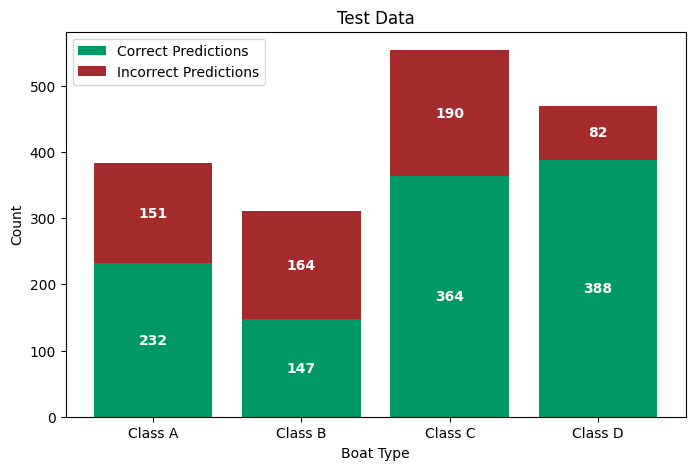

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      232       20       20      111
1       41      147       60       63
2       84       36      364       70
3       56        9       17      388

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.561743  0.605744  0.582915  0.658324
1  Class 1   0.693396  0.472669  0.562141  0.658324
2  Class 2   0.789588  0.657040  0.717241  0.658324
3  Class 3   0.613924  0.825532  0.704174  0.658324
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_52 (LSTM)              (None, 6, 128)            73728     
                                                                 
 dropout_106 (Dropout)       (None, 6, 128)            0         
                                                                 
 lstm_53 (LSTM)              (None, 64)                49408     
                                     

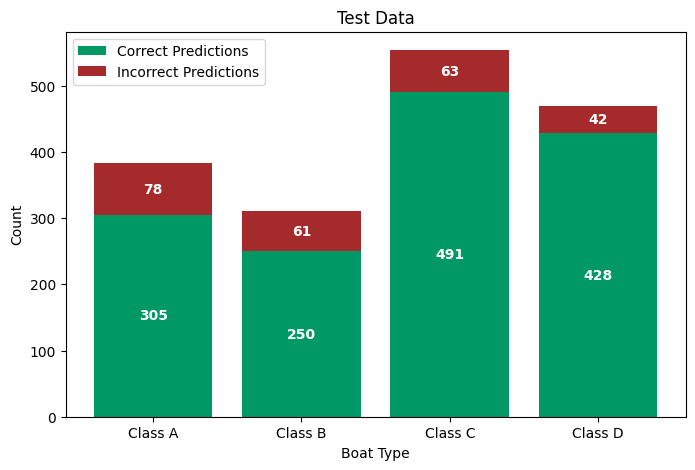

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      305       17       32       29
1       14      250       36       11
2       26       15      491       22
3       21        7       14      428

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.833333  0.796345  0.814419  0.857974
1  Class 1   0.865052  0.803859  0.833333  0.857974
2  Class 2   0.856894  0.886282  0.871340  0.857974
3  Class 3   0.873469  0.910638  0.891667  0.857974
Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_54 (LSTM)              (None, 1, 128)            590848    
                                                                 
 dropout_110 (Dropout)       (None, 1, 128)            0         
                                                                 
 lstm_55 (LSTM)              (None, 64)                49408     
                                     

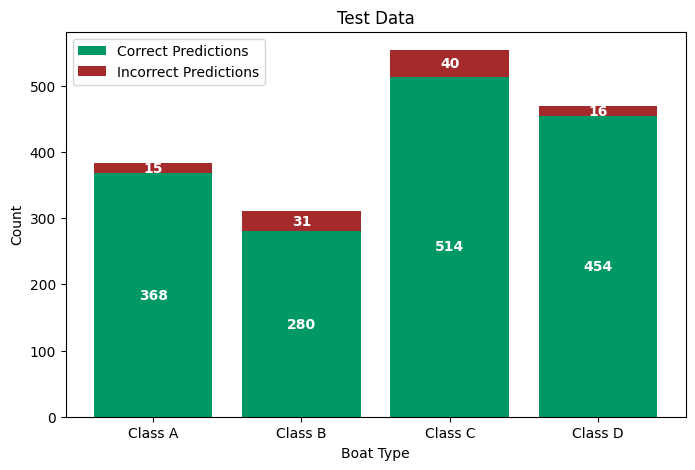

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      368        7        4        4
1       10      280       16        5
2       14       17      514        9
3        6        4        6      454

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.924623  0.960836  0.942382  0.940629
1  Class 1   0.909091  0.900322  0.904685  0.940629
2  Class 2   0.951852  0.927798  0.939671  0.940629
3  Class 3   0.961864  0.965957  0.963907  0.940629
Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_56 (LSTM)              (None, 200, 128)          78848     
                                                                 
 dropout_114 (Dropout)       (None, 200, 128)          0         
                                                                 
 lstm_57 (LSTM)              (None, 64)                49408     
                                     

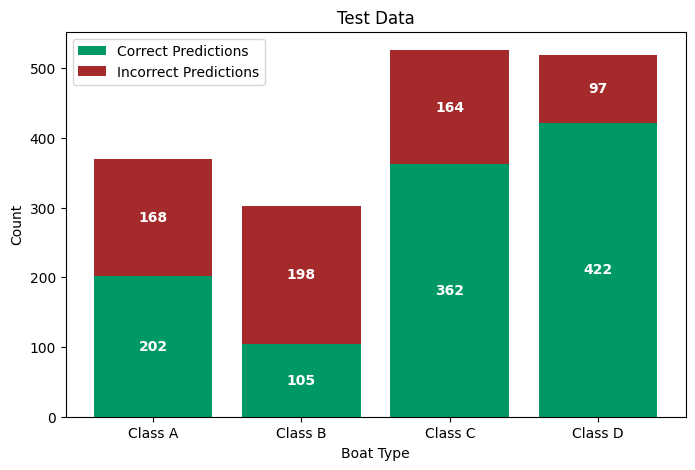

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      202       14       33      121
1       42      105      103       53
2       66       38      362       60
3       56        7       34      422

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.551913  0.545946  0.548913  0.635041
1  Class 1   0.640244  0.346535  0.449679  0.635041
2  Class 2   0.680451  0.688213  0.684310  0.635041
3  Class 3   0.643293  0.813102  0.718298  0.635041
Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_58 (LSTM)              (None, 6, 128)            73728     
                                                                 
 dropout_118 (Dropout)       (None, 6, 128)            0         
                                                                 
 lstm_59 (LSTM)              (None, 64)                49408     
                                     

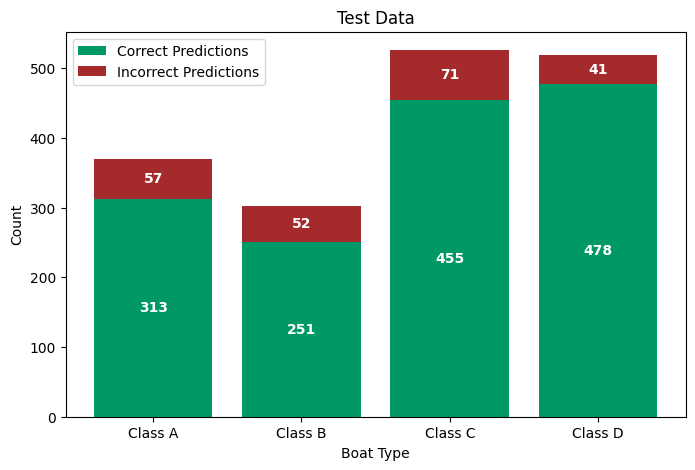

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      313        9       29       19
1       12      251       36        4
2       35       19      455       17
3       14       15       12      478

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.836898  0.845946  0.841398  0.871362
1  Class 1   0.853741  0.828383  0.840871  0.871362
2  Class 2   0.855263  0.865019  0.860113  0.871362
3  Class 3   0.922780  0.921002  0.921890  0.871362
Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_60 (LSTM)              (None, 1, 128)            590848    
                                                                 
 dropout_122 (Dropout)       (None, 1, 128)            0         
                                                                 
 lstm_61 (LSTM)              (None, 64)                49408     
                                     

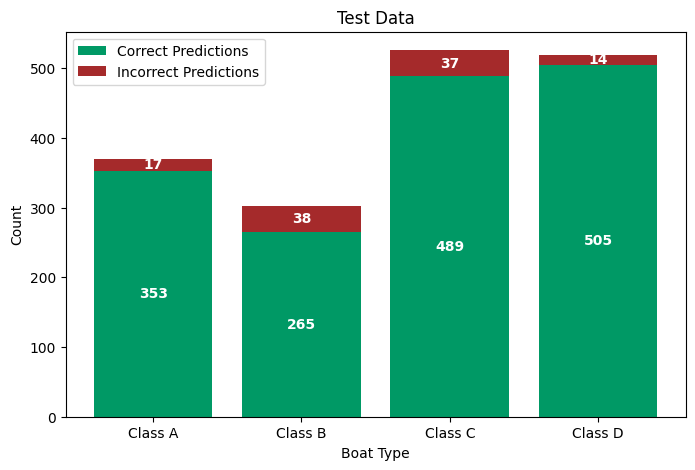

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      353        3        8        6
1        7      265       24        7
2       15       12      489       10
3        3        3        8      505

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.933862  0.954054  0.943850    0.9383
1  Class 1   0.936396  0.874587  0.904437    0.9383
2  Class 2   0.924386  0.929658  0.927014    0.9383
3  Class 3   0.956439  0.973025  0.964661    0.9383
Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_62 (LSTM)              (None, 200, 128)          78848     
                                                                 
 dropout_126 (Dropout)       (None, 200, 128)          0         
                                                                 
 lstm_63 (LSTM)              (None, 64)                49408     
                                     

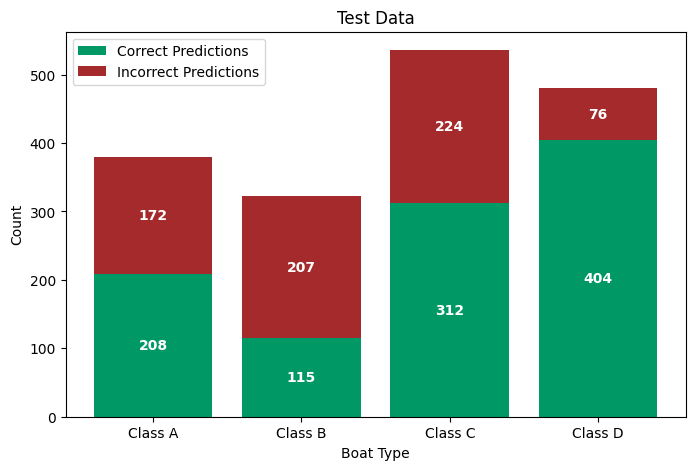

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      208       19       30      123
1       58      115       87       62
2       96       44      312       84
3       45        8       23      404

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.511057  0.547368  0.528590  0.604773
1  Class 1   0.618280  0.357143  0.452756  0.604773
2  Class 2   0.690265  0.582090  0.631579  0.604773
3  Class 3   0.600297  0.841667  0.700781  0.604773
Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_64 (LSTM)              (None, 6, 128)            73728     
                                                                 
 dropout_130 (Dropout)       (None, 6, 128)            0         
                                                                 
 lstm_65 (LSTM)              (None, 64)                49408     
                                     

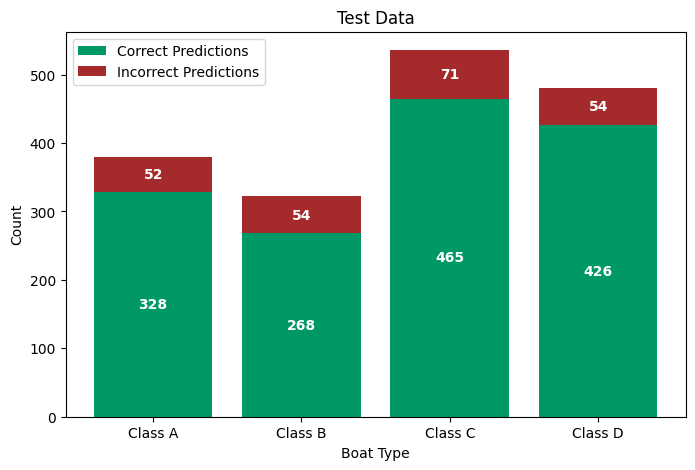

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      328       10       22       20
1       17      268       24       13
2       31       23      465       17
3       30       12       12      426

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.807882  0.863158  0.834606  0.865541
1  Class 1   0.856230  0.832298  0.844094  0.865541
2  Class 2   0.889101  0.867537  0.878187  0.865541
3  Class 3   0.894958  0.887500  0.891213  0.865541
Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_66 (LSTM)              (None, 1, 128)            590848    
                                                                 
 dropout_134 (Dropout)       (None, 1, 128)            0         
                                                                 
 lstm_67 (LSTM)              (None, 64)                49408     
                                     

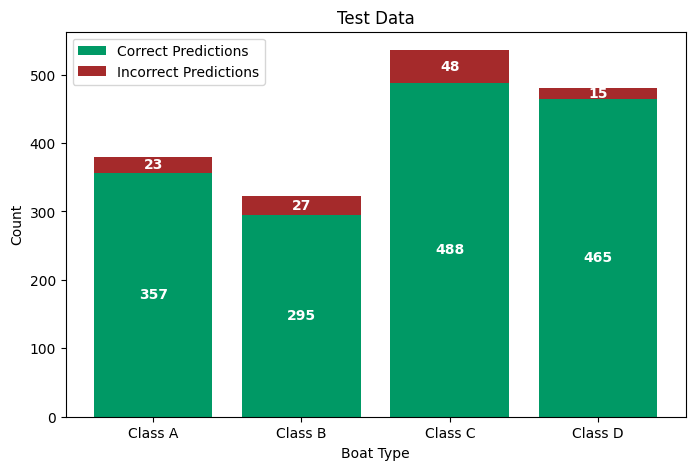

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      357        3       11        9
1       10      295       13        4
2       13       18      488       17
3        5        3        7      465

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.927273  0.939474  0.933333  0.934226
1  Class 1   0.924765  0.916149  0.920437  0.934226
2  Class 2   0.940270  0.910448  0.925118  0.934226
3  Class 3   0.939394  0.968750  0.953846  0.934226
Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_68 (LSTM)              (None, 200, 128)          78848     
                                                                 
 dropout_138 (Dropout)       (None, 200, 128)          0         
                                                                 
 lstm_69 (LSTM)              (None, 64)                49408     
                                     

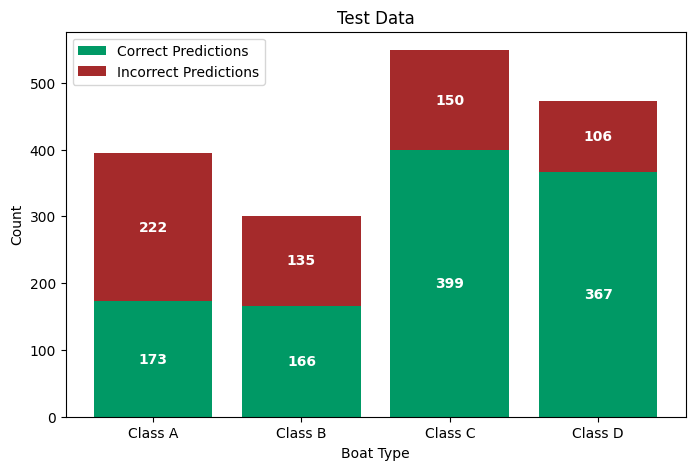

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      173       32       75      115
1       21      166       77       37
2       37       40      399       73
3       34       19       53      367

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.652830  0.437975  0.524242   0.64319
1  Class 1   0.645914  0.551495  0.594982   0.64319
2  Class 2   0.660596  0.726776  0.692108   0.64319
3  Class 3   0.619932  0.775899  0.689202   0.64319
Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_70 (LSTM)              (None, 6, 128)            73728     
                                                                 
 dropout_142 (Dropout)       (None, 6, 128)            0         
                                                                 
 lstm_71 (LSTM)              (None, 64)                49408     
                                     

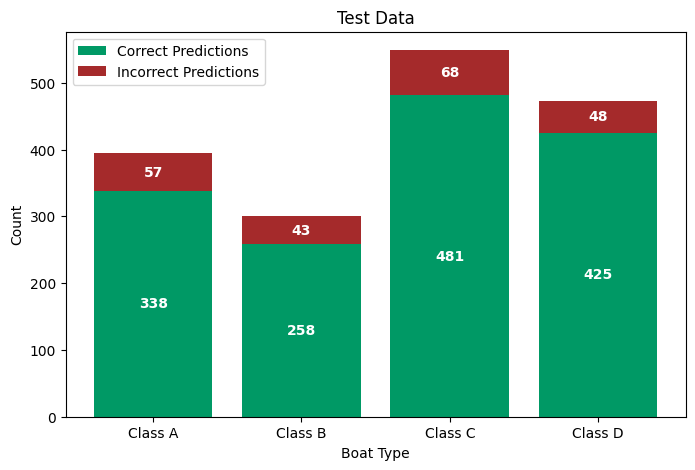

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      338       13       20       24
1       10      258       25        8
2       20       23      481       25
3       23        8       17      425

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.864450  0.855696  0.860051  0.874272
1  Class 1   0.854305  0.857143  0.855721  0.874272
2  Class 2   0.885820  0.876138  0.880952  0.874272
3  Class 3   0.881743  0.898520  0.890052  0.874272
Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_72 (LSTM)              (None, 1, 128)            590848    
                                                                 
 dropout_146 (Dropout)       (None, 1, 128)            0         
                                                                 
 lstm_73 (LSTM)              (None, 64)                49408     
                                     

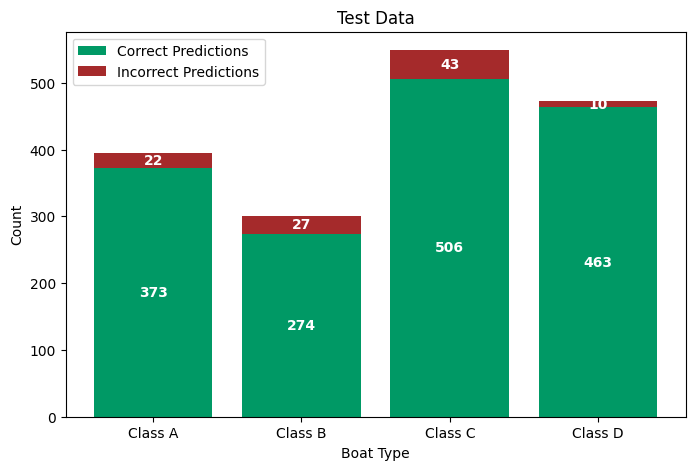

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      373        3       10        9
1        7      274       18        2
2       12       14      506       17
3        2        0        8      463

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.946701  0.944304  0.945501  0.940629
1  Class 1   0.941581  0.910299  0.925676  0.940629
2  Class 2   0.933579  0.921676  0.927589  0.940629
3  Class 3   0.942974  0.978858  0.960581  0.940629
Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_74 (LSTM)              (None, 200, 128)          78848     
                                                                 
 dropout_150 (Dropout)       (None, 200, 128)          0         
                                                                 
 lstm_75 (LSTM)              (None, 64)                49408     
                                     

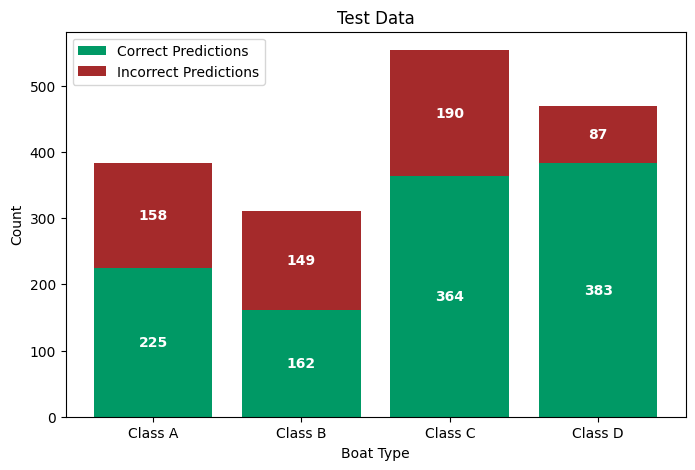

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      225       19       35      104
1       38      162       54       57
2       71       48      364       71
3       42       16       29      383

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.598404  0.587467  0.592885   0.66007
1  Class 1   0.661224  0.520900  0.582734   0.66007
2  Class 2   0.755187  0.657040  0.702703   0.66007
3  Class 3   0.622764  0.814894  0.705991   0.66007
Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_76 (LSTM)              (None, 6, 128)            73728     
                                                                 
 dropout_154 (Dropout)       (None, 6, 128)            0         
                                                                 
 lstm_77 (LSTM)              (None, 64)                49408     
                                     

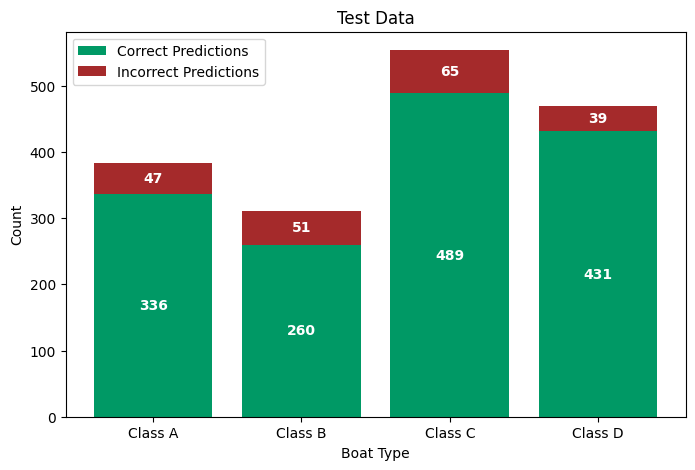

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      336       11       15       21
1       10      260       29       12
2       24       25      489       16
3       16        9       14      431

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.870466  0.877285  0.873862  0.882421
1  Class 1   0.852459  0.836013  0.844156  0.882421
2  Class 2   0.893967  0.882671  0.888283  0.882421
3  Class 3   0.897917  0.917021  0.907368  0.882421
Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_78 (LSTM)              (None, 1, 128)            590848    
                                                                 
 dropout_158 (Dropout)       (None, 1, 128)            0         
                                                                 
 lstm_79 (LSTM)              (None, 64)                49408     
                                     

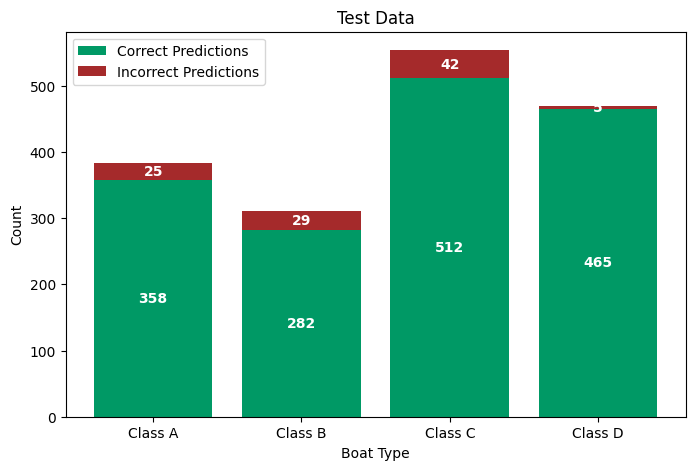

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      358        7       12        6
1        5      282       21        3
2        9       23      512       10
3        1        0        4      465

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.959786  0.934726  0.947090  0.941211
1  Class 1   0.903846  0.906752  0.905297  0.941211
2  Class 2   0.932605  0.924188  0.928377  0.941211
3  Class 3   0.960744  0.989362  0.974843  0.941211


In [ ]:
#@title 5.2 Test results extraction

# Metric activator
raw = 1
mfcc = 1
psd = 1


metrics_raw1 = []
metrics_mfcc1 = []
metrics_psd1 = []
matrix_raw = []
matrix_mfcc = []
matrix_psd = []
val = 1
data = ['data1.pkl','data2.pkl','data3.pkl','data4.pkl','data5.pkl']

for d in data:
  X_train, X_test, X_val, y_train, y_test, y_val = dataload(d)
  if raw == 1:
  # Get raw data
    X_train_r = restruct(200,25,X_train)
    X_test_r = restruct(200,25,X_test)
    X_val_r = restruct(200,25,X_val)
    metrics, matrix = get_LSTM_raw(val)
    metrics_raw1.append(metrics)
    matrix_raw.append(matrix)
  if mfcc == 1:
  # Get mfcc data
    mfcc_train, mfcc_val, mfcc_test = get_mfcc()

    mfcc_train_r = restruct(6,15,mfcc_train)
    mfcc_test_r = restruct(6,15,mfcc_test)
    mfcc_val_r = restruct(6,15, mfcc_val)
    metrics1, matrix1 = get_LSTM_mfcc(val)
    metrics_mfcc1.append(metrics1)
    matrix_mfcc.append(matrix1)
 # Get psd data
  if psd == 1:
    psd_train, psd_val, psd_test = get_psd()
    psd_train_r = restruct(1,1025,psd_train)
    psd_test_r = restruct(1,1025,psd_test)
    psd_val_r = restruct(1,1025, psd_val)
    metrics2, matrix2 = get_LSTM_psd(val)
    metrics_psd1.append(metrics2)
    matrix_psd.append(matrix2)
  val = val + 1

pd.options.display.float_format = '{:.3f}'.format

if raw == 1:
  metrics_raw = metrics_avg_var(metrics_raw1)
if mfcc == 1:
  metrics_mfcc = metrics_avg_var(metrics_mfcc1)
if psd == 1:
  metrics_psd = metrics_avg_var(metrics_psd1)


In [ ]:
#@title Print Table

def get_number(row,col, metrics):
 cols = ['Precision','Recall','F1 Score']
 a = metrics.at[row,col]
 highest = 0
 if col in cols:
  for value in metrics[col]:
    if value > a:
      highest = 1
  if highest == 0:
    a = "\highest{" + str(a) + "}"
 return str(a)

def print_table(metrics):

#metrics table formatting


  columns_to_format = ['Precision',
                        'Recall',
                        'F1 Score',
                          'Accuracy']
  metrics[columns_to_format] = metrics[columns_to_format].round(3)
  columns_to_format = ['P_std','R_std','F1_std','Acc_std']
  metrics[columns_to_format] = metrics[columns_to_format].round(3)


  print(
  "Class A                           & " + get_number(0,'Precision',metrics) + "                               & (" + get_number(0,'P_std',metrics) + ")     & " + get_number(0,'Recall',metrics) + "                         & (" + get_number(0,'R_std',metrics) + ")         & " + get_number(0,'F1 Score',metrics) + "                  & (" + get_number(0,'F1_std',metrics) + ")                   \\\\"
  " \\rowcolor[HTML]{EFEFEF} Class B                           & " + get_number(1,'Precision',metrics) + "                               & (" + get_number(1,'P_std',metrics) + ")      & " + get_number(1,'Recall',metrics) + "                         & (" + get_number(1,'R_std',metrics) + ")         & " + get_number(1,'F1 Score',metrics) + "                  & (" + get_number(1,'F1_std',metrics) + ")                  \\\\"
  "Class C                           & " + get_number(2,'Precision',metrics) + "                               & (" + get_number(2,'P_std',metrics) + ")      & " + get_number(2,'Recall',metrics) + "                        & (" + get_number(2,'R_std',metrics) + ")         & " + get_number(2,'F1 Score',metrics) + "                  & (" + get_number(2,'F1_std',metrics) + ")                  \\\\")
  print("\\rowcolor[HTML]{EFEFEF} "
  "Class D                           & " + get_number(3,'Precision',metrics) + "                              & (" + get_number(3,'P_std',metrics) + ")      & " + get_number(3,'Recall',metrics) + "                         & (" + get_number(3,'R_std',metrics) + ")         & " + get_number(3,'F1 Score',metrics) + "                  & (" + get_number(3,'F1_std',metrics) + ")                 \\\\ \midrule"
  "\\multicolumn{1}{c}{\\textbf{Accuracy($\sigma$)}} & \multicolumn{1}{c}{\\textbf{}}       &            & \multicolumn{1}{l}{}          &               & \\textbf{" + get_number(3,'Accuracy',metrics) + "}         & \\textbf{(" + get_number(2,'Acc_std',metrics) + ")}  ")
  return


print_table(metrics_psd)

Class A                           & 0.938                               & (0.013)     & 0.947                         & (0.01)         & 0.942                  & (0.005)                   \\ \rowcolor[HTML]{EFEFEF} Class B                           & 0.923                               & (0.015)      & 0.902                         & (0.014)         & 0.912                  & (0.009)                  \\Class C                           & 0.937                               & (0.009)      & 0.923                        & (0.007)         & 0.93                  & (0.005)                  \\
\rowcolor[HTML]{EFEFEF} Class D                           & \highest{0.952}                              & (0.009)      & \highest{0.975}                         & (0.008)         & \highest{0.964}                  & (0.007)                 \\ \midrule\multicolumn{1}{c}{\textbf{Accuracy($\sigma$)}} & \multicolumn{1}{c}{\textbf{}}       &            & \multicolumn{1}{l}{}          &               & \te

In [ ]:
#@title Print Matrix

def get_max_matrix(matrix):
  a = 0
  pos = 5
  tp_max = 0
  for m in matrix:
    tp = sum(np.diagonal(m))
    if tp_max < tp:
      tp_max = tp
      pos = a
    a = a+1
  return pos

def get_matrix(matrix):
  matrix = matrix[get_max_matrix(matrix)]
  col = ['Class A','Class B','Class C','Class D']
  for i in list(range(4)):
    for j in list(range(4)):
      print(j,i,matrix.at[i,col[j]])

print("x y C")
get_matrix(matrix_psd)


x y C
0 0 358
1 0 7
2 0 12
3 0 6
0 1 5
1 1 282
2 1 21
3 1 3
0 2 9
1 2 23
2 2 512
3 2 10
0 3 1
1 3 0
2 3 4
3 3 465
